### Build env for this notebook (temp. fix):

Running this on CPU with different environment, as tensorflow does not support 5000-series Nvidia GPUs yet.

The SVM notebooks have to be executed first, as they create and export the feature data. Then this notebook is run in the dnn_cpu environment, see Readme.md


## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
)
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer

import seaborn as sns
from subpred.evaluation import plot_results_long
from subpred.util import save_results, load_data
import random
import pickle

2025-06-09 17:10:26.046032: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 17:10:26.173661: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Setting random seeds for all libraries. The seed for TF is a starting seed, and will get incremented with each call of Dropout(). Therefore, the notebook has to be restarted to get the same results again.

In [2]:
import random
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)  

Reading feature data from SVM notebook

In [3]:
# importing feature data from SVM notebooks (they have to be run first)
import pickle
TEST_NAME = f"dnn_human_sugaramino"
with open("../data/tmp_data/svc_human_sugaramino_ml_data.pickle", "rb") as handle:
    ml_datasets = pickle.load(handle)

Trying three different architectures, as the features have different sizes ranging from 400 to 8000. High dropout of 0.5 should take care of most overfitting problems.

In [4]:
from tensorflow import keras

# Test result AT sugar amino: the three models perform very similarly, just use the simplest one (create_model)
# Tried different values for dropout (0.0,0.3,0.5,0.7), performance for non-0 is similar.
# Dropout 0.5 for smaller datasets, maybe try 0.3 for larger
# Tried different values for batch_size. Not really a big difference. 8 for smaller (less overfitting), 16 or 32 for larger (more speed)
# TODO put this code into subpred package, once TF is compatible with new GPU


def create_model(n_features):
    # Larger datasets: try lower dropout
    # Try starting at lower number of nodes
    model = keras.Sequential(
        [
            keras.layers.Input(shape=(n_features,)),
            keras.layers.Dense(512, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.F1Score(average="macro", name="F1_macro"),
            keras.metrics.TruePositives(name="TP"),
            keras.metrics.TrueNegatives(name="TN"),
            keras.metrics.FalsePositives(name="FP"),
            keras.metrics.FalseNegatives(name="FN"),
        ],
    )
    return model


def create_model_dynamic_nodes(n_features):
    if n_features > 1024:
        layer_sizes = [1024, 512, 256]
        print("selecting large model")
    elif n_features > 512:  # includes embeddings with len 1024
        layer_sizes = [512, 256, 128]
        print("selecting medium model")
    else:
        layer_sizes = [256, 128, 64]
        print("selecting small model")
    model = keras.Sequential(
        [
            keras.layers.Input(shape=(n_features,)),
            keras.layers.Dense(layer_sizes[0], activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(layer_sizes[1], activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(layer_sizes[2], activation="relu"),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.F1Score(average="macro", name="F1_macro"),
            keras.metrics.TruePositives(name="TP"),
            keras.metrics.TrueNegatives(name="TN"),
            keras.metrics.FalsePositives(name="FP"),
            keras.metrics.FalseNegatives(name="FN"),
        ],
    )
    return model


def create_model_dynamic_layers(n_features):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(n_features,)))
    for layer_size in [2048, 1024, 512, 256]:
        if n_features >= layer_size:
            model.add(keras.layers.Dense(layer_size, activation="relu"))
            model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.F1Score(average="macro", name="F1_macro"),
            keras.metrics.TruePositives(name="TP"),
            keras.metrics.TrueNegatives(name="TN"),
            keras.metrics.FalsePositives(name="FP"),
            keras.metrics.FalseNegatives(name="FN"),
        ],
    )

    return model

In [5]:
pd.Series(ml_datasets[0].y).value_counts()

0    25
1    22
Name: count, dtype: int64

## Evaluation

In [6]:
from sklearn.utils.class_weight import compute_class_weight


def crossval_dnn(
    ml_dataset,
    model_func,
    scores_dict,
    splits=5,
    repeats=5,
    epochs=100,
    batch_size=8,
    verbose=False,
    calculate_class_weights=False,
):
    print(f"=== {ml_dataset.name} ===")
    preprocess = make_pipeline(VarianceThreshold(0.0), StandardScaler())

    X, y = ml_dataset.X, ml_dataset.y

    train_scores = list()
    test_scores = list()
    fold_count = 1
    for train_idx_outer, val_idx_outer in RepeatedStratifiedKFold(
        n_splits=splits, n_repeats=repeats, random_state=0
    ).split(X, y):
        if verbose:
            print(f"Fold {fold_count} out of {splits*repeats}")
        fold_count += 1

        X_train, X_test = X[train_idx_outer], X[val_idx_outer]
        y_train, y_test = y[train_idx_outer], y[val_idx_outer]

        X_train = preprocess.fit_transform(X_train, y_train)
        X_test = preprocess.transform(X_test)

        # important: create from scratch to reset weights
        model = model_func(X_train.shape[1])
        # TODO Early Stopping can be an option for larger datasets (less overfitting, faster training)
        # TODO class weights option
        if calculate_class_weights:
            classes = np.sort(np.unique(y_train))
            class_weights = compute_class_weight(
                class_weight="balanced", classes=classes, y=y_train
            )
            class_weights_dict = dict(zip(classes, class_weights))
        training_history = model.fit(
            X_train,
            y_train.reshape(-1, 1),
            epochs=epochs,
            batch_size=batch_size,
            verbose="auto" if verbose else 0,
            class_weight=class_weights_dict,
        )
        y_prob = model.predict(X_test, verbose="auto" if verbose else 0)
        y_pred = (y_prob > 0.5).astype(int).flatten()
        # TODO log mis-classified samples: always the same ones?

        for score_name, score_func in scores_dict.items():
            test_scores.append(
                (ml_dataset.name, score_name, score_func(y_test, y_pred))
            )
            if verbose:
                print(score_name, score_func(y_test, y_pred))

        res = model.evaluate(
            X_test, y_test.reshape(-1, 1), verbose="auto" if verbose else 0
        )
        if verbose:
            print(res)
    df_scores = pd.DataFrame(test_scores, columns=["Feature", "Metric", "Value"])

    return df_scores

In [7]:
for pos, ml_dataset in enumerate(ml_datasets):
    print(pos, ml_dataset.name, len(ml_dataset.feature_names))

0 DUMMY 1024
1 AAC 20
2 PAAC 400
3 AA_KMER3 8000
4 3Di_COMP 20
5 3Di_KMER2 400
6 3Di_KMER3 8000
7 COMB_KMER1 40
8 COMB_KMER2 800
9 COMB_KMER3 16000
10 PROTT5_AA 1024
11 PROSTT5_AA 1024
12 PROSTT5_3DI 1024
13 PSSM_50_1 400
14 PSSM_50_3 400
15 PSSM_90_1 400
16 PSSM_90_3 400
17 PSSM_META 1600
18 META 2020
19 META_STD 2020


Using the same metrics as with the SVM, to compare the results better

In [8]:
scoring_outer = {
    "Balanced Accuracy": balanced_accuracy_score,
    "F1 Macro": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, average="macro"
    ),
    "F1 Class 0": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, pos_label=0
    ),
    "F1 Class 1": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, pos_label=1
    ),
}


Caching of results. A new test always needs a new test_name, otherwise it reads the old results.

In [9]:
from pathlib import Path
if Path(f"../data/results/{TEST_NAME}.pickle").exists():
    df_results_all = load_data(TEST_NAME, folder_path="../data/results")
else:
    results = [
        crossval_dnn(
            ml_dataset=ml_dataset,
            model_func=create_model,
            scores_dict=scoring_outer,
            splits=5,
            repeats=5,
            epochs=50,
            batch_size=8,
            calculate_class_weights=True
        )
        for ml_dataset in ml_datasets
    ]
    df_results_all = pd.concat(results)
    save_results(df_results_all,TEST_NAME, folder_path="../data/results")
        

## Plots

In [10]:
# same plot as for svm, to compare
df_results_plot = df_results_all.copy()
df_results_plot.Feature = df_results_plot.Feature.str.replace("_", "-").replace("PSSM-META","MULTI-PSSM")
df_results_plot = df_results_plot[~df_results_plot.Feature.str.match(r'^PSSM-\d+')]
df_results_plot = df_results_plot[~df_results_plot.Feature.str.startswith("COMB")]
feature_order = [
    "DUMMY",
    "AAC",
    "PAAC",
    "AA-KMER3",
    # "PSSM-50-1",
    # "PSSM-50-3",
    # "PSSM-90-1",
    # "PSSM-90-3",
    # "PSSM-META",
    "MULTI-PSSM",
    "META",
    "META-STD",
    "PROTT5-AA",
    "PROSTT5-AA",
    "PROSTT5-3DI",
    "3Di-COMP",
    "3Di-KMER2",
    "3Di-KMER3",
    # "COMB-KMER1",
    # "COMB-KMER2",
    # "COMB-KMER3",
]

In [11]:
df_results_plot.Feature.unique()

array(['DUMMY', 'AAC', 'PAAC', 'AA-KMER3', '3Di-COMP', '3Di-KMER2',
       '3Di-KMER3', 'PROTT5-AA', 'PROSTT5-AA', 'PROSTT5-3DI',
       'MULTI-PSSM', 'META', 'META-STD'], dtype=object)

saves plot with test name and metrics in name

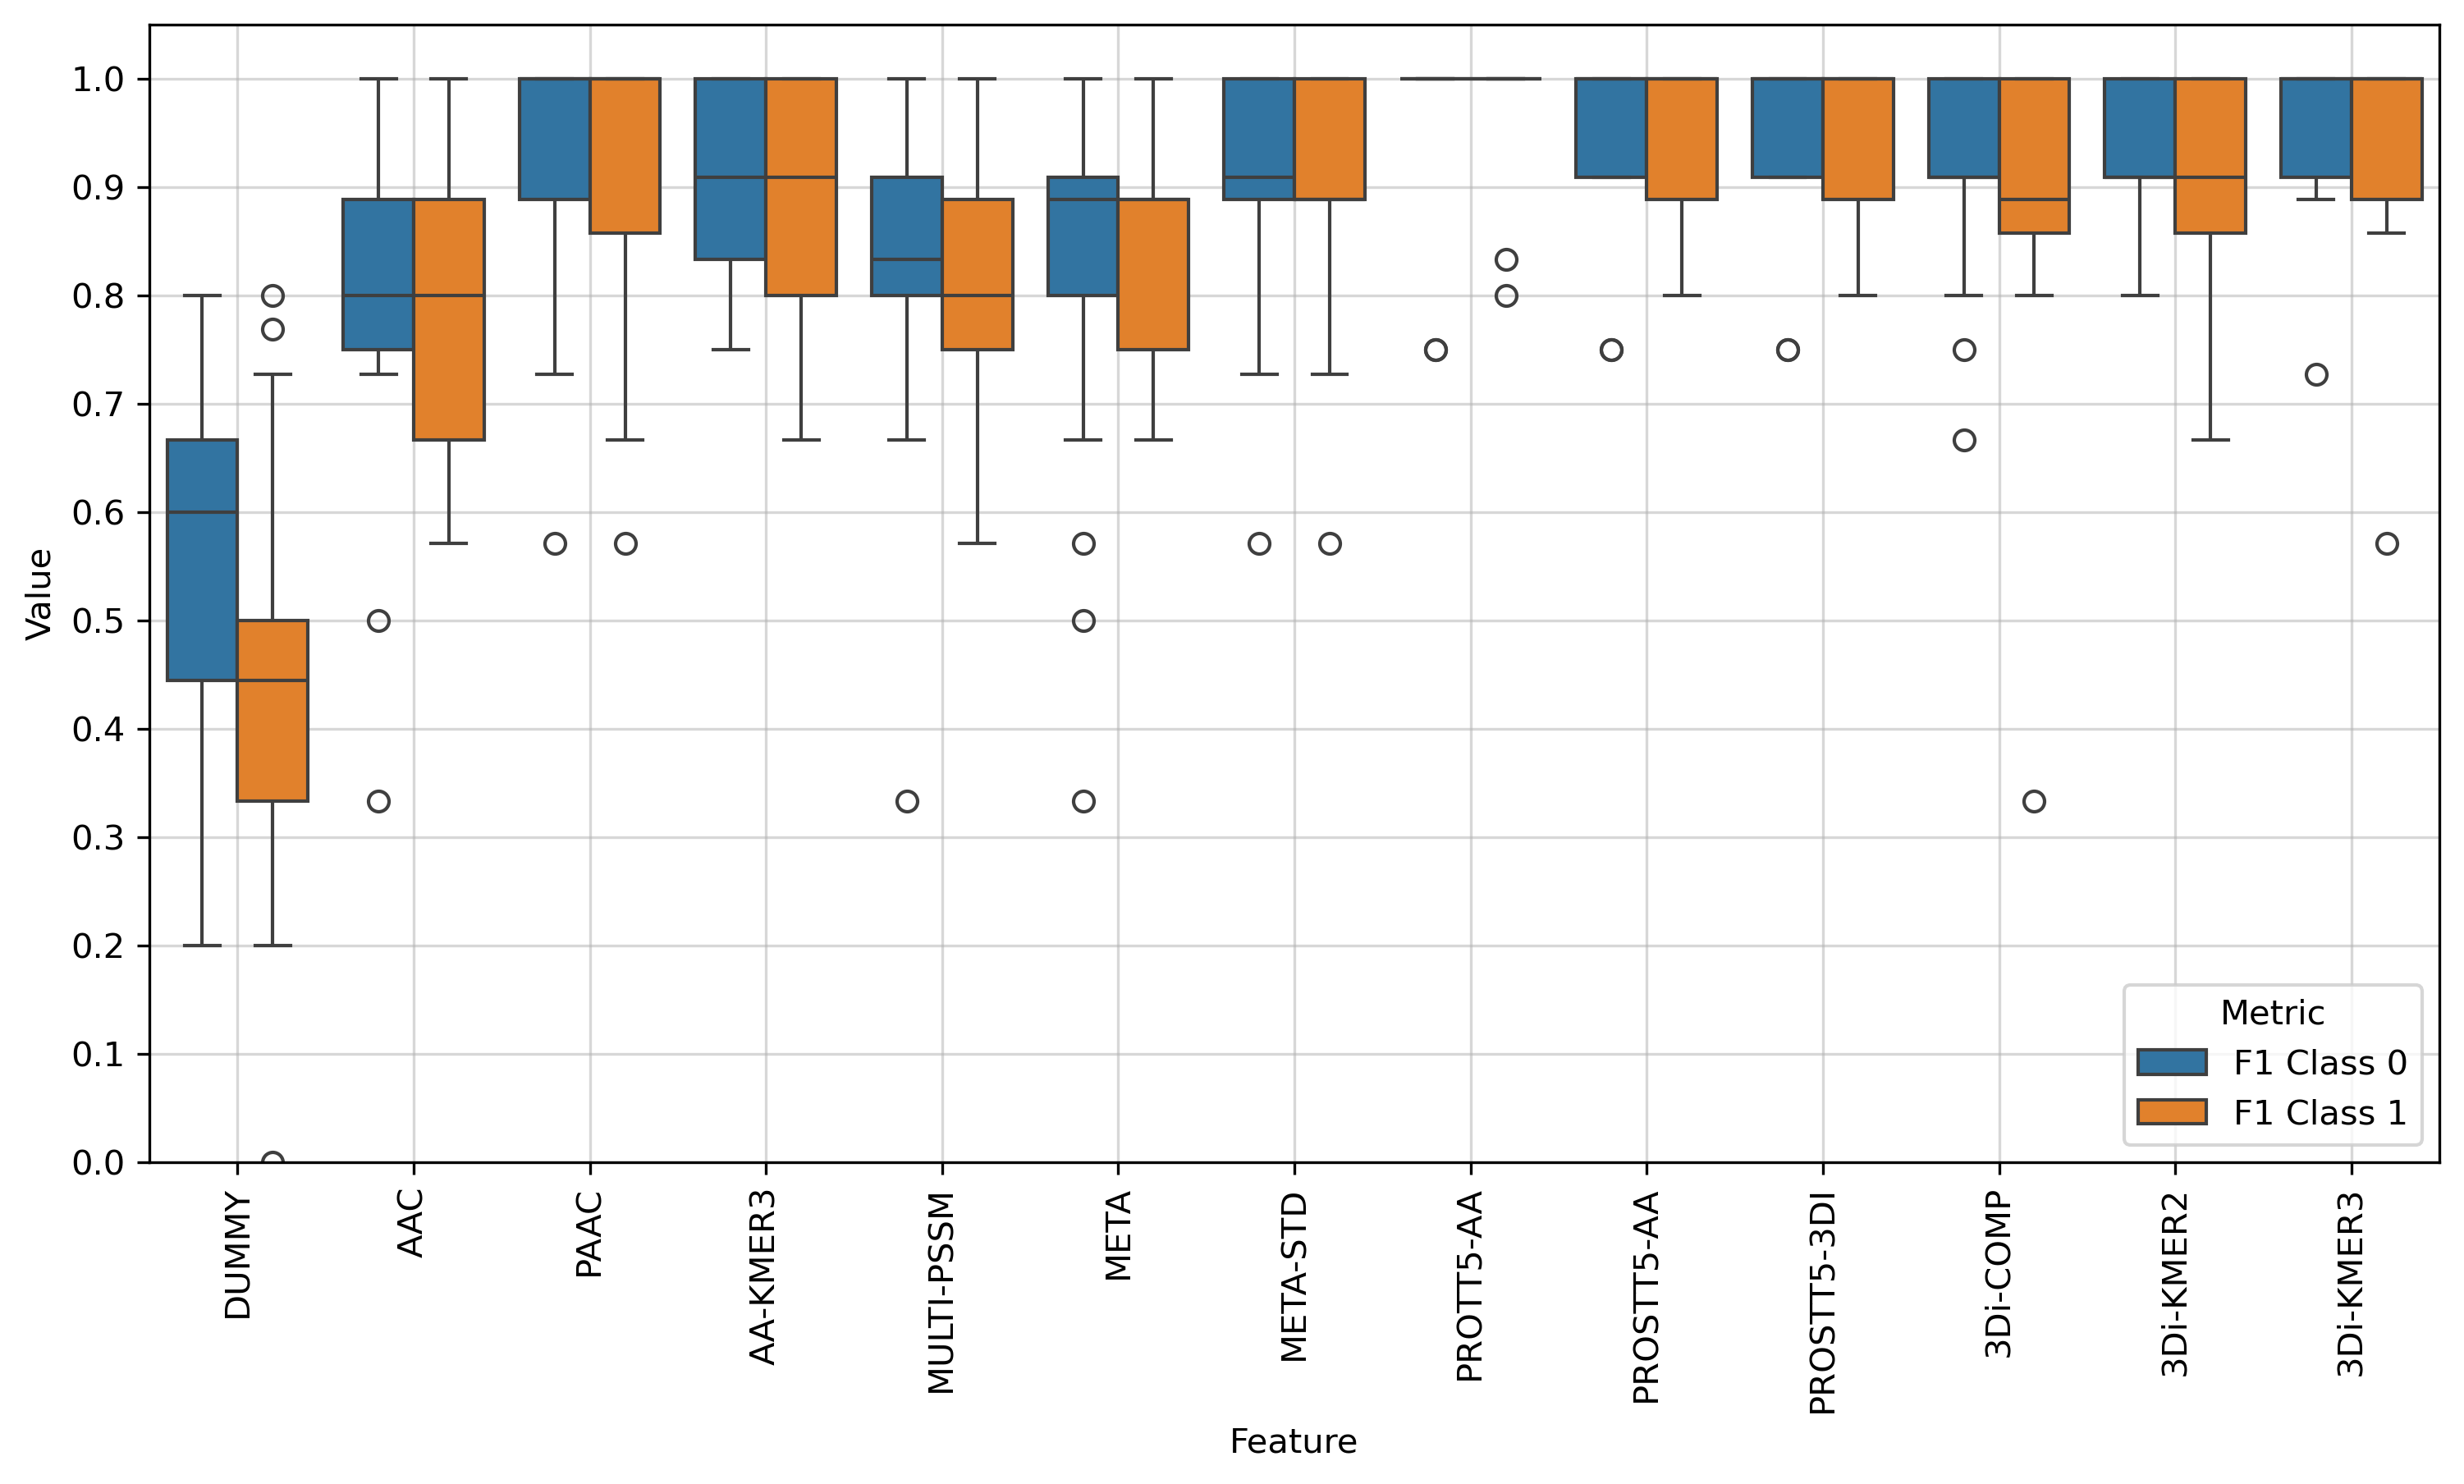

In [12]:
plot_results_long(
    df_results_long=df_results_plot,
    output_folder_path="../data/results/",
    test_name=TEST_NAME,
    plot_order=feature_order,
    metrics_include=["F1 Class 0", "F1 Class 1"],
)

## Tables

In [13]:
df_table = df_results_all.copy()
df_table.Feature = df_table.Feature.str.replace("_", "-").replace("PSSM-META","MULTI-PSSM")
df_table = df_table[~df_table.Feature.str.match(r'^PSSM-\d+')]
feature_order = [
    "DUMMY",
    "AAC",
    "PAAC",
    "AA-KMER3",
    # "PSSM-META",
    "MULTI-PSSM",
    "META",
    "META-STD",
    "COMB-KMER1",
    "COMB-KMER2",
    "COMB-KMER3",
    "PROTT5-AA",
    "PROSTT5-AA",
    "PROSTT5-3DI",
    # "PSSM-50-1",
    # "PSSM-50-3",
    # "PSSM-90-1",
    # "PSSM-90-3",
    "3Di-COMP",
    "3Di-KMER2",
    "3Di-KMER3",
]

df_table_mean = df_table.groupby(["Feature", "Metric"]).mean().reset_index().pivot(
    index="Feature", columns="Metric", values="Value"
)
df_table_std = df_table.groupby(["Feature", "Metric"]).std().reset_index().pivot(
    index="Feature", columns="Metric", values="Value"
)

df_table_paper = df_table_mean.map(lambda x: f"{x:.3f}").astype(str) + "±" + df_table_std.map(lambda x: f"{x:.3f}").astype(str)
df_table_paper = df_table_paper.loc[feature_order]
df_table_paper

Metric,Balanced Accuracy,F1 Class 0,F1 Class 1,F1 Macro
Feature,,,,
DUMMY,0.519±0.149,0.556±0.151,0.460±0.184,0.508±0.152
AAC,0.804±0.119,0.807±0.146,0.788±0.134,0.797±0.130
PAAC,0.915±0.113,0.921±0.112,0.905±0.130,0.913±0.118
AA-KMER3,0.908±0.100,0.913±0.094,0.898±0.117,0.906±0.103
MULTI-PSSM,0.825±0.104,0.828±0.135,0.807±0.116,0.818±0.116
META,0.846±0.119,0.829±0.166,0.846±0.109,0.837±0.134
META-STD,0.923±0.096,0.922±0.106,0.917±0.104,0.920±0.102
COMB-KMER1,0.905±0.091,0.917±0.082,0.893±0.108,0.905±0.092
COMB-KMER2,0.924±0.104,0.930±0.107,0.916±0.116,0.923±0.109


In [14]:
df_table_paper.columns.name = None
print(
    df_table_paper.reset_index(drop=False)
    .drop("F1 Macro", axis=1)
    .to_latex(index=False)
    .replace("tabular", "tabular*")
    .replace("{llll}", "{\\textwidth}{@{\\extracolsep{\\fill}} lrrr}")
)

\begin{tabular*}{\textwidth}{@{\extracolsep{\fill}} lrrr}
\toprule
Feature & Balanced Accuracy & F1 Class 0 & F1 Class 1 \\
\midrule
DUMMY & 0.519±0.149 & 0.556±0.151 & 0.460±0.184 \\
AAC & 0.804±0.119 & 0.807±0.146 & 0.788±0.134 \\
PAAC & 0.915±0.113 & 0.921±0.112 & 0.905±0.130 \\
AA-KMER3 & 0.908±0.100 & 0.913±0.094 & 0.898±0.117 \\
MULTI-PSSM & 0.825±0.104 & 0.828±0.135 & 0.807±0.116 \\
META & 0.846±0.119 & 0.829±0.166 & 0.846±0.109 \\
META-STD & 0.923±0.096 & 0.922±0.106 & 0.917±0.104 \\
COMB-KMER1 & 0.905±0.091 & 0.917±0.082 & 0.893±0.108 \\
COMB-KMER2 & 0.924±0.104 & 0.930±0.107 & 0.916±0.116 \\
COMB-KMER3 & 0.950±0.081 & 0.956±0.071 & 0.946±0.089 \\
PROTT5-AA & 0.984±0.055 & 0.980±0.069 & 0.985±0.051 \\
PROSTT5-AA & 0.956±0.069 & 0.958±0.074 & 0.954±0.071 \\
PROSTT5-3DI & 0.961±0.067 & 0.962±0.074 & 0.959±0.068 \\
3Di-COMP & 0.906±0.103 & 0.920±0.084 & 0.892±0.136 \\
3Di-KMER2 & 0.931±0.076 & 0.944±0.060 & 0.921±0.091 \\
3Di-KMER3 & 0.955±0.081 & 0.962±0.066 & 0.948±0.097 \\
\bo